# this is a script for CMIP6 historical SST

In [1]:
% ERA5 SST 1940-2022
load('/nexsan/people/fyang/work/Data/ERA5/sst.mat');
sstERA=sst;
lon2=lon;lat2=lat;

# CMIP6

## read

In [6]:
path='/nexsan/people/fyang/CMIP6/historical_sst/';
files=dir(path);files=files(3:end);
modelname="";tt=1;

for m=1:size(files,1)
    aa=files(m).name;aa=aa(10:end-17);
    if(strcmp(modelname(tt,1),aa));continue;end
    modelname(tt+1,1)=aa;
    tt=tt+1;
end
modelname=modelname(2:end,1);

In [7]:
modelname(1)


ans = 

    "ACCESS-CM2_historical_r10i1p1f1_gn"



In [6]:
fid=fopen('a.txt','w');
fprintf(fid,'%s\n',modelname);
fclose(fid);

## regrid & phase

In [20]:
parpool(20)

Starting parallel pool (parpool) using the 'Processes' profile ...
Connected to the parallel pool (number of workers: 20).

ans = 

 ProcessPool with properties: 

            Connected: true
           NumWorkers: 20
                 Busy: false
              Cluster: Processes (Local Cluster)
        AttachedFiles: {}
    AutoAddClientPath: true
            FileStore: [1x1 parallel.FileStore]
           ValueStore: [1x1 parallel.ValueStore]
          IdleTimeout: 30 minutes (30 minutes remaining)
          SpmdEnabled: true



In [40]:
sst_model=nan*zeros(55,7,12*161,size(modelname,1));
parfor mmodel=1:size(modelname,1)

files=dir(append(path,'*',modelname(mmodel),'*'));
filepath=append(path,files(1).name);
aa=ncinfo(filepath);
if(sum(strcmp('longitude',{aa.Variables.Name}))>.5);
    lon=ncread(filepath,'longitude');
    lat=ncread(filepath,'latitude');
else
    lon=ncread(filepath,'lon');
    lat=ncread(filepath,'lat');
end
if(size(lon,1)<1.01|size(lon,2)<1.01);[lat,lon]=meshgrid(lat,lon);end
lon(lon<-.01)=lon(lon<-.01)+360;
lon(lon>359.99)=lon(lon>359.99)-360;

tos=[];tt=0;
for mfile=1:size(files,1)
    filepath=append(path,files(mfile).name);
    aa=ncread(filepath,'tos');
    tos(:,:,tt+1:tt+size(aa,3))=aa;
    tt=size(tos,3);
end
tos=tos(:,:,1:161*12);
tos(tos>400)=nan;tos(tos<-10)=nan;
aa=std(tos,1,3)>.1;bb=zeros(size(aa))+1;
bb(aa<.5)=nan;tos=tos.*bb;
if(mean(mean(tos(:,:,100*12),1,'omitnan'),2,'omitnan')<100);tos=tos+273.15;end

lon(lon>-.01&lon<40.01)=lon(lon>-.01&lon<40.01)+360;
tos=reshape(tos,[],size(tos,3));
lon=reshape(lon,[],1);lat=reshape(lat,[],1);
sst=nan*zeros(55,7,12*161);
for mlon=1:55
for nlat=1:7

    xx=lon>(5*mlon+115)-2.51&lon<(5*mlon+115)+2.51;
    yy=lat>(-5*nlat+65)-2.51&lat<(-5*nlat+65)+2.51;
    aa=tos(xx&yy,:);
    if(sum(isnan(mean(aa,2)))>.5*size(aa,1));continue;end
    sst(mlon,nlat,:)=mean(aa,1,'omitnan');

end
end
sst_model(:,:,:,mmodel)=sst;
mmodel
end


ans =

     5


ans =

     2


ans =

     8


ans =

    15


ans =

    18


ans =

     4


ans =

     6


ans =

     7


ans =

     9


ans =

    10


ans =

    13


ans =

    19


ans =

    20


ans =

     1


ans =

     3


ans =

    12


ans =

    16


ans =

    17


ans =

    11


ans =

    14


ans =

    65


ans =

    59


ans =

    53


ans =

    68


ans =

    56


ans =

    62


ans =

    35


ans =

    64


ans =

    58


ans =

    74


ans =

    26


ans =

    47


ans =

    80


ans =

    52


ans =

    77


ans =

    67


ans =

    55


ans =

    61


ans =

    71


ans =

    63


ans =

    32


ans =

    38


ans =

    23


ans =

    57


ans =

    29


ans =

    51


ans =

    44


ans =

    50


ans =

    66


ans =

    54


ans =

    60


ans =

    70


ans =

    34


ans =

    73


ans =

    79


ans =

    76


ans =

    25


ans =

    69


ans =

    41


ans =

    83


ans =

    31


ans =

    22


ans =



In [21]:
ps_model=nan*zeros(55,7,161,3,size(modelname,1));
parfor mmodel=1:size(modelname,1)

sst=sst_model(:,:,:,mmodel);
ps=nan*zeros(55,7,161,3);
for mlon=1:55
for nlat=1:7

    aa=reshape(sst(mlon,nlat,:),[],1);
    if(isnan(mean(aa,1)));continue;end
    tt1=((1:size(aa,1))'-.5)/12*365;
    tt2=(1:size(aa,1)/12*365)';
    aa0=interp1(tt1,aa,tt2);
    aa0=reshape(aa0,[],1);
    %tt=15;aa=0*aa0;
    %for mm1=1:2*tt+1
    %    aa(tt+1:end-tt)=aa(tt+1:end-tt)+aa0(mm1:end-(2*tt+1-mm1));
    %end
    %aa0(tt+1:end-tt)=aa(tt+1:end-tt)/(2*tt+1);
    
    % (1) FT
    aa1=reshape(aa0,365,[]);
    aa1=aa1(:,2:end-1);
    m=1;
    aa2=mean((aa1-mean(aa1,1)).*exp(1i*2*pi*m.*reshape(1:365,[],1)/365),1);
    aa2=2*real(aa2.*exp(-1i*2*pi*m.*reshape(1:365,[],1)/365));
    [vv,imax]=max(aa2,[],1);
    ps(mlon,nlat,2:end-1,1)=squeeze(imax);

    % (2) Summer&Winter
    aa2=reshape(aa0,365,[]);
    aa2=mean(aa2(:,2:end-1),2);
    [~,offset]=max(aa2,[],1);
    tt=offset-182:offset+182;tt(tt<.1)=tt(tt<.1)+365;tt(tt>365.1)=tt(tt>365.1)-365;
    aa2=aa2(tt);
    n=10;
    aa2=aa2(1+10*(n-1):365-10*(n-1));aa2=aa2-mean(aa2,1);
    tt=(size(aa2,1)-1)/2;aa=0*aa0;bb=0*aa0;cc=0*aa0;
    for ms1=1:2*tt+1
        bb(tt+1:end-tt)=bb(tt+1:end-tt)+aa0(ms1:end-(2*tt+1-ms1));
    end
    bb(tt+1:end-tt)=bb(tt+1:end-tt)/(2*tt+1);
    for ms2=1:2*tt+1
        aa(tt+1:end-tt)=aa(tt+1:end-tt)+aa0(ms2:end-(2*tt+1-ms2))*aa2(ms2);
        cc(tt+1:end-tt)=cc(tt+1:end-tt)+(aa0(ms2:end-(2*tt+1-ms2))-bb(tt+1:end-tt)).^2;
    end
    aa1=aa./sqrt(cc*sum(aa2.^2,1));
    aa1=reshape(aa1(offset+183:end-2*365+offset+182),365,[]);
    [vv,imax]=max(reshape(aa1,365,[]),[],1);
    imax(vv<.9)=nan;imax(imax<183-45|imax>183+45)=nan;
    ps(mlon,nlat,2:end-1,2)=squeeze(imax)+offset-183;

    aa2=reshape(aa0,365,[]);
    aa2=mean(aa2(:,2:end-1),2);
    [~,offset]=min(aa2,[],1);
    tt=offset-182:offset+182;tt(tt<.1)=tt(tt<.1)+365;tt(tt>365.1)=tt(tt>365.1)-365;
    aa2=aa2(tt);
    n=10;
    aa2=aa2(1+10*(n-1):365-10*(n-1));aa2=aa2-mean(aa2,1);
    tt=(size(aa2,1)-1)/2;aa=0*aa0;bb=0*aa0;cc=0*aa0;
    for mw1=1:2*tt+1
        bb(tt+1:end-tt)=bb(tt+1:end-tt)+aa0(mw1:end-(2*tt+1-mw1));
    end
    bb(tt+1:end-tt)=bb(tt+1:end-tt)/(2*tt+1);
    for mw2=1:2*tt+1
        aa(tt+1:end-tt)=aa(tt+1:end-tt)+aa0(mw2:end-(2*tt+1-mw2))*aa2(mw2);
        cc(tt+1:end-tt)=cc(tt+1:end-tt)+(aa0(mw2:end-(2*tt+1-mw2))-bb(tt+1:end-tt)).^2;
    end
    aa1=aa./sqrt(cc*sum(aa2.^2,1));
    aa1=reshape(aa1(offset+183:end-2*365+offset+182),365,[]);
    [vv,imax]=max(reshape(aa1,365,[]),[],1);
    imax(vv<.9)=nan;imax(imax<183-45|imax>183+45)=nan;
    ps(mlon,nlat,2:end-1,3)=squeeze(imax)+offset-183;

end
end
ps_model(:,:,:,:,mmodel)=ps;
mmodel
end


ans =

    12


ans =

    13


ans =

    14


ans =

    18


ans =

    20


ans =

     6


ans =

     8


ans =

    17


ans =

     4


ans =

     5


ans =

    19


ans =

     1


ans =

     9


ans =

    11


ans =

     2


ans =

     7


ans =

     3


ans =

    10


ans =

    16


ans =

    15


ans =

    74


ans =

    80


ans =

    38


ans =

    71


ans =

    77


ans =

    32


ans =

    35


ans =

    56


ans =

    23


ans =

    26


ans =

    59


ans =

    47


ans =

    29


ans =

    41


ans =

    44


ans =

    62


ans =

    53


ans =

    50


ans =

    68


ans =

    65


ans =

    79


ans =

    73


ans =

    37


ans =

    76


ans =

    31


ans =

    34


ans =

    25


ans =

    22


ans =

    70


ans =

    55


ans =

    28


ans =

    40


ans =

    46


ans =

    43


ans =

    58


ans =

    52


ans =

    49


ans =

    61


ans =

    67


ans =

    72


ans =

    78


ans =

    64


ans =



In [10]:
delete(gcp('nocreate'))

# ERA5

In [2]:
mask1=sstERA([111:360,1:41],1:90,:,1:82);

ps_era=nan*zeros(55,7,size(mask1,4),3);
for mlon=1:55
for nlat=1:7

aa0=mask1(5*mlon+6+(-2:2),5*nlat+26+(-2:2),:,:);
if(sum(reshape(isnan(mean(mean(aa0(:,:,:,10:30),3),4)),[],1))>12);
continue;
end
aa0=reshape(mean(mean(aa0,1,'omitnan'),2,'omitnan'),[],1);
tt=15;aa=0*aa0;
for m=1:2*tt+1
    aa(tt+1:end-tt)=aa(tt+1:end-tt)+aa0(m:end-(2*tt+1-m));
end
aa0(tt+1:end-tt)=aa(tt+1:end-tt)/(2*tt+1);

% (1) FT
aa1=reshape(aa0,365,[]);
aa1=aa1(:,2:end-1);
m=1;
aa2=mean((aa1-mean(aa1,1)).*exp(1i*2*pi*m.*reshape(1:365,[],1)/365),1);
aa2=2*real(aa2.*exp(-1i*2*pi*m.*reshape(1:365,[],1)/365));
[vv,ps]=max(aa2,[],1);
ps_era(mlon,nlat,2:end-1,1)=squeeze(ps);

% (2) Summer&Winter
aa2=reshape(aa0,365,[]);
aa2=mean(aa2(:,2:end-1),2);
[~,offset]=max(aa2,[],1);
tt=offset-182:offset+182;tt(tt<.1)=tt(tt<.1)+365;tt(tt>365.1)=tt(tt>365.1)-365;
aa2=aa2(tt);
n=10;
aa2=aa2(1+10*(n-1):365-10*(n-1));aa2=aa2-mean(aa2,1);
tt=(size(aa2,1)-1)/2;aa=0*aa0;bb=0*aa0;cc=0*aa0;
for m=1:2*tt+1
    bb(tt+1:end-tt)=bb(tt+1:end-tt)+aa0(m:end-(2*tt+1-m));
end
bb(tt+1:end-tt)=bb(tt+1:end-tt)/(2*tt+1);
for m=1:2*tt+1
    aa(tt+1:end-tt)=aa(tt+1:end-tt)+aa0(m:end-(2*tt+1-m))*aa2(m);
    cc(tt+1:end-tt)=cc(tt+1:end-tt)+(aa0(m:end-(2*tt+1-m))-bb(tt+1:end-tt)).^2;
end
aa1=aa./sqrt(cc*sum(aa2.^2,1));
aa1=reshape(aa1(offset+183:end-2*365+offset+182),365,[]);
[vv,ps]=max(reshape(aa1,365,[]),[],1);
ps(vv<.9)=nan;ps(ps<183-45|ps>183+45)=nan;
ps_era(mlon,nlat,2:end-1,2)=squeeze(ps)+offset-183;

aa2=reshape(aa0,365,[]);
aa2=mean(aa2(:,2:end-1),2);
[~,offset]=min(aa2,[],1);
tt=offset-182:offset+182;tt(tt<.1)=tt(tt<.1)+365;tt(tt>365.1)=tt(tt>365.1)-365;
aa2=aa2(tt);
n=10;
aa2=aa2(1+10*(n-1):365-10*(n-1));aa2=aa2-mean(aa2,1);
tt=(size(aa2,1)-1)/2;aa=0*aa0;bb=0*aa0;cc=0*aa0;
for m=1:2*tt+1
    bb(tt+1:end-tt)=bb(tt+1:end-tt)+aa0(m:end-(2*tt+1-m));
end
bb(tt+1:end-tt)=bb(tt+1:end-tt)/(2*tt+1);
for m=1:2*tt+1
    aa(tt+1:end-tt)=aa(tt+1:end-tt)+aa0(m:end-(2*tt+1-m))*aa2(m);
    cc(tt+1:end-tt)=cc(tt+1:end-tt)+(aa0(m:end-(2*tt+1-m))-bb(tt+1:end-tt)).^2;
end
aa1=aa./sqrt(cc*sum(aa2.^2,1));
aa1=reshape(aa1(offset+183:end-2*365+offset+182),365,[]);
[vv,ps]=max(reshape(aa1,365,[]),[],1);
ps(vv<.9)=nan;ps(ps<183-45|ps>183+45)=nan;
ps_era(mlon,nlat,2:end-1,3)=squeeze(ps)+offset-183;

end
end

# compare: mean state

In [4]:
aa=ps_model(:,:,82:160,2:3,:);
tt=5;bb=0*aa;
for m=1:2*tt+1
    bb(:,:,tt+1:end-tt,:,:)=bb(:,:,tt+1:end-tt,:,:)+aa(:,:,m:end-(2*tt+1-m),:,:);
end
%aa1=nan*aa;aa2=nan*aa;
aa1=bb(:,:,tt+1:end-tt,:,:)/(2*tt+1);
aa2=aa(:,:,tt+1:end-tt,:,:)-bb(:,:,tt+1:end-tt,:,:)/(2*tt+1);
aa1=aa1-mean(aa1,3);
aa1=sum(aa1.^2,3)/size(aa1,3);
aa1=reshape(sqrt(aa1),[],size(aa1,4),size(aa1,5));
aa2=aa2-mean(aa2,3);
aa2=sum(aa2.^2,3)/size(aa2,3);
aa2=reshape(sqrt(aa2),[],size(aa2,4),size(aa2,5));
stdl_m=squeeze(mean(aa1,1,'omitnan'))';
stdh_m=squeeze(mean(aa2,1,'omitnan'))';
stdr_m=stdl_m./stdh_m;

aa=ps_era(:,:,2:end-1,2:3);
tt=5;bb=0*aa;
for m=1:2*tt+1
    bb(:,:,tt+1:end-tt,:)=bb(:,:,tt+1:end-tt,:)+aa(:,:,m:end-(2*tt+1-m),:);
end
%aa1=nan*aa;aa2=nan*aa;
aa1=bb(:,:,tt+1:end-tt,:)/(2*tt+1);
aa2=aa(:,:,tt+1:end-tt,:)-bb(:,:,tt+1:end-tt,:)/(2*tt+1);
aa1=aa1-mean(aa1,3);
aa1=sum(aa1.^2,3)/size(aa1,3);
aa1=reshape(sqrt(aa1),[],size(aa1,4));
aa2=aa2-mean(aa2,3);
aa2=sum(aa2.^2,3)/size(aa2,3);
aa2=reshape(sqrt(aa2),[],size(aa2,4));
stdl=squeeze(mean(aa1,1,'omitnan'));
stdh=squeeze(mean(aa2,1,'omitnan'));

aa=ps_model(1:13,2:6,92:160,2:3,:);
ps1=squeeze(mean(mean(aa,1,'omitnan'),2,'omitnan'));
aa=ps_model(13:25,2:6,92:160,2:3,:);
ps1(:,:,:,2)=squeeze(mean(mean(aa,1,'omitnan'),2,'omitnan'));
aa=ps_model(35:47,2:6,92:160,2:3,:);
ps1(:,:,:,3)=squeeze(mean(mean(aa,1,'omitnan'),2,'omitnan'));

aa=ps_era(1:13,2:6,2:70,2:3);
ps2=squeeze(mean(mean(aa,1,'omitnan'),2,'omitnan'));
aa=ps_era(13:25,2:6,2:70,2:3);
ps2(:,:,2)=squeeze(mean(mean(aa,1,'omitnan'),2,'omitnan'));
aa=ps_era(35:47,2:6,2:70,2:3);
ps2(:,:,3)=squeeze(mean(mean(aa,1,'omitnan'),2,'omitnan'));
ps2=reshape(ps2,size(ps2,1),size(ps2,2),1,size(ps2,3));
mn=reshape(mean(ps1-ps2,1),size(ps1,2),[],size(ps1,4));

save('scatter_model.mat','stdl_m','stdh_m','stdl','stdh','mn');

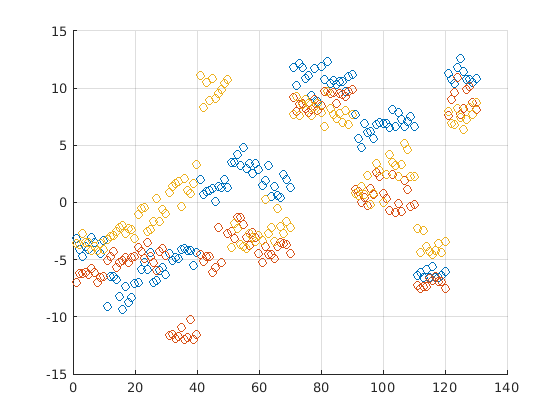

In [5]:
figure;scatter(1:130,mn(1,:,1));
hold on;grid on;
scatter(1:130,mn(1,:,2));
scatter(1:130,mn(1,:,3));

# low-frequent component compare

## model & observation

In [6]:
aa=ps_model(1:13,2:6,92:160,2:3,:);
ps1=squeeze(mean(mean(aa,1,'omitnan'),2,'omitnan'));
aa=ps_model(13:25,2:6,92:160,2:3,:);
ps1(:,:,:,2)=squeeze(mean(mean(aa,1,'omitnan'),2,'omitnan'));
aa=ps_model(35:47,2:6,92:160,2:3,:);
ps1(:,:,:,3)=squeeze(mean(mean(aa,1,'omitnan'),2,'omitnan'));

aa=ps_era(1:13,2:6,2:70,2:3);
ps2=squeeze(mean(mean(aa,1,'omitnan'),2,'omitnan'));
aa=ps_era(13:25,2:6,2:70,2:3);
ps2(:,:,2)=squeeze(mean(mean(aa,1,'omitnan'),2,'omitnan'));
aa=ps_era(35:47,2:6,2:70,2:3);
ps2(:,:,3)=squeeze(mean(mean(aa,1,'omitnan'),2,'omitnan'));
ps2=reshape(ps2,size(ps2,1),size(ps2,2),1,size(ps2,3));

tt=5;aa=0*ps1;bb=0*ps2;
for m=1:2*tt+1
    aa(tt+1:end-tt,:,:,:)=aa(tt+1:end-tt,:,:,:)+ps1(m:end-(2*tt+1-m),:,:,:);
    bb(tt+1:end-tt,:,:,:)=bb(tt+1:end-tt,:,:,:)+ps2(m:end-(2*tt+1-m),:,:,:);
end
aa1=aa(tt+1:end-tt,:,:,:)/(2*tt+1);
aa2=bb(tt+1:end-tt,:,:,:)/(2*tt+1);

aa1=aa1-mean(aa1,1);aa2=aa2-mean(aa2,1);
corr=squeeze(sum(aa1.*aa2,1)./sqrt(sum(aa1.^2,1).*sum(aa2.^2,1)));
corr=reshape(corr,size(corr,1),10,[],size(corr,3));

save('model_era_corr.mat','corr');

## inter-model compare

In [7]:
aa=ps_model(1:13,2:6,2:160,2:3,:);
aa=squeeze(mean(mean(aa,1,'omitnan'),2,'omitnan'));
tt=5;bb=0*aa;
for m=1:2*tt+1
    bb(tt+1:end-tt,:,:)=bb(tt+1:end-tt,:,:)+aa(m:end-(2*tt+1-m),:,:);
end
%aa1=nan*aa;aa2=nan*aa;
aa0=bb(tt+1:end-tt,:,:)/(2*tt+1);
rr=nan*zeros(size(aa0,3),size(aa0,3),size(aa0,2));
for m=1:size(aa0,3)
    for n=1:m-1
        aa1=aa0(:,:,m);aa1=aa1-mean(aa1,1);
        aa2=aa0(:,:,n);aa2=aa2-mean(aa2,1);
        aa=sum(aa1.*aa2,1)./sqrt(sum(aa1.^2,1).*sum(aa2.^2,1));
        rr(m,n,:)=aa;
    end
end
ptn_rr=rr;

aa=ps_model(13:25,2:6,2:160,2:3,:);
aa=squeeze(mean(mean(aa,1,'omitnan'),2,'omitnan'));
tt=5;bb=0*aa;
for m=1:2*tt+1
    bb(tt+1:end-tt,:,:)=bb(tt+1:end-tt,:,:)+aa(m:end-(2*tt+1-m),:,:);
end
%aa1=nan*aa;aa2=nan*aa;
aa0=bb(tt+1:end-tt,:,:)/(2*tt+1);
rr=nan*zeros(size(aa0,3),size(aa0,3),size(aa0,2));
for m=1:size(aa0,3)
    for n=1:m-1
        aa1=aa0(:,:,m);aa1=aa1-mean(aa1,1);
        aa2=aa0(:,:,n);aa2=aa2-mean(aa2,1);
        aa=sum(aa1.*aa2,1)./sqrt(sum(aa1.^2,1).*sum(aa2.^2,1));
        rr(m,n,:)=aa;
    end
end
ptn_rr(:,:,:,2)=rr;

aa=ps_model(35:47,2:6,2:160,2:3,:);
aa=squeeze(mean(mean(aa,1,'omitnan'),2,'omitnan'));
tt=5;bb=0*aa;
for m=1:2*tt+1
    bb(tt+1:end-tt,:,:)=bb(tt+1:end-tt,:,:)+aa(m:end-(2*tt+1-m),:,:);
end
%aa1=nan*aa;aa2=nan*aa;
aa0=bb(tt+1:end-tt,:,:)/(2*tt+1);
rr=nan*zeros(size(aa0,3),size(aa0,3),size(aa0,2));
for m=1:size(aa0,3)
    for n=1:m-1
        aa1=aa0(:,:,m);aa1=aa1-mean(aa1,1);
        aa2=aa0(:,:,n);aa2=aa2-mean(aa2,1);
        aa=sum(aa1.*aa2,1)./sqrt(sum(aa1.^2,1).*sum(aa2.^2,1));
        rr(m,n,:)=aa;
    end
end
ptn_rr(:,:,:,3)=rr;

rr=ptn_rr;ptn_rr=[];self_rr=[];
for m=1:size(rr,1)/10
    for n=1:size(rr,1)/10
        aa=rr(1+10*(m-1):10*m,1+10*(n-1):10*n,:,:);
        aa=reshape(aa,[],size(aa,3),size(aa,4));
        ptn_rr(m,n,:,:)=mean(aa,1,'omitnan');
    end
    aa=rr(1+10*(m-1):10*m,1+10*(m-1):10*m,:,:);
    aa=reshape(aa,[],size(aa,3),size(aa,4));
    aa=aa(~isnan(aa(:,1,1)),:,:);
    self_rr(:,:,:,m)=aa;
end

%mm = cellstr(modelname);
save('model_self_corr.mat','self_rr');